In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '../../../'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
from vsOED.utils import *
from vsOED.models import *

import dowel
import joblib

print('==============================================================================')
print('Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py')
print('and change def _load_from_bytes(b):')
print('to')
print(f'    return torch.load(io.BytesIO(b), map_location="{dev}")')
print('==============================================================================')

Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py
and change def _load_from_bytes(b):
to
    return torch.load(io.BytesIO(b), map_location="cpu")


# Only interested in model kld (model)

In [38]:
data_folder = parent_dir + './results/source/multimodel/model/'
subfolders = {'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [41]:
# read in gmm results
hs = [1, 5, 10, 15, 20, 30]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 6), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                # res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation.pt', map_location=device)
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation_with_post_approx.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

/tmp/ipykernel_2214630/196506147.py:4: RuntimeWarning: Mean of empty slice
  rwds = np.nanmean(gmm_rwds[mode], axis=0)


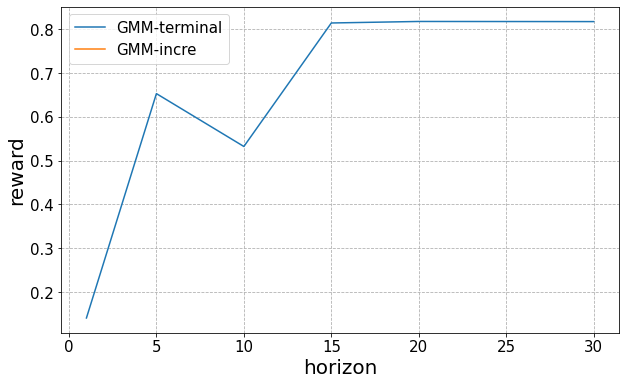

In [42]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
for mode in ['terminal', 'incre']:
    rwds = np.nanmean(gmm_rwds[mode], axis=0)
    plt.plot(hs, rwds, label=f'GMM-{mode}')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

In [28]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 1
h = 20
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

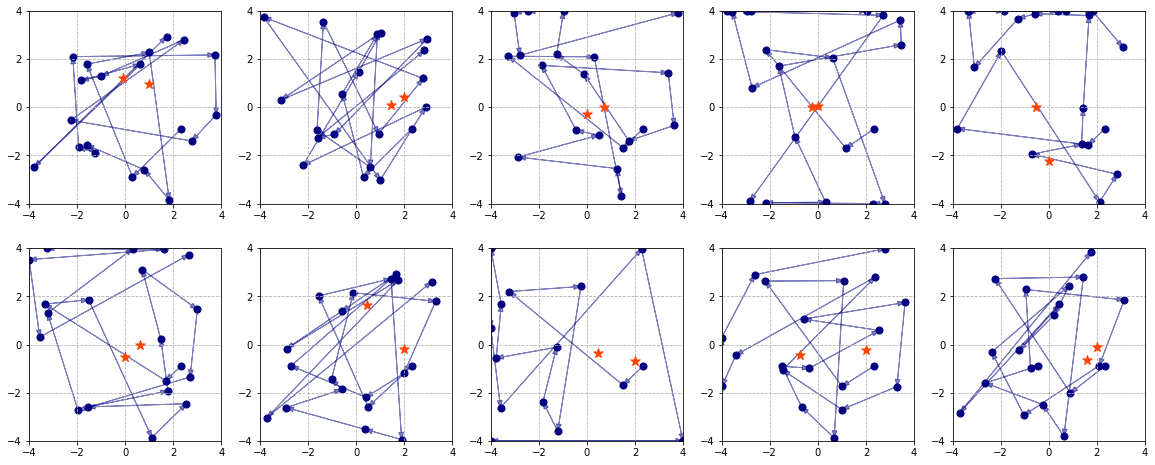

In [29]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(int(param[0])+1):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.grid(ls='--')

# Only interested in parameter of interest kld (poi)

In [30]:
data_folder = parent_dir + './results/source/multimodel/poi/'
subfolders = {'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [36]:
# read in gmm results
hs = [1, 5, 10, 15, 20, 30]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 6), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

/tmp/ipykernel_2214630/196506147.py:4: RuntimeWarning: Mean of empty slice
  rwds = np.nanmean(gmm_rwds[mode], axis=0)


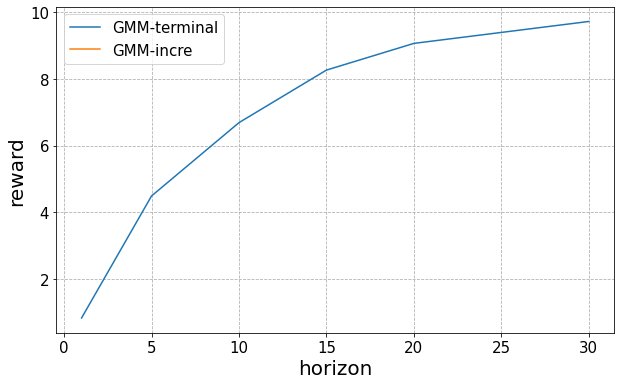

In [37]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
for mode in ['terminal', 'incre']:
    rwds = np.nanmean(gmm_rwds[mode], axis=0)
    plt.plot(hs, rwds, label=f'GMM-{mode}')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

In [33]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 1
h = 20
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

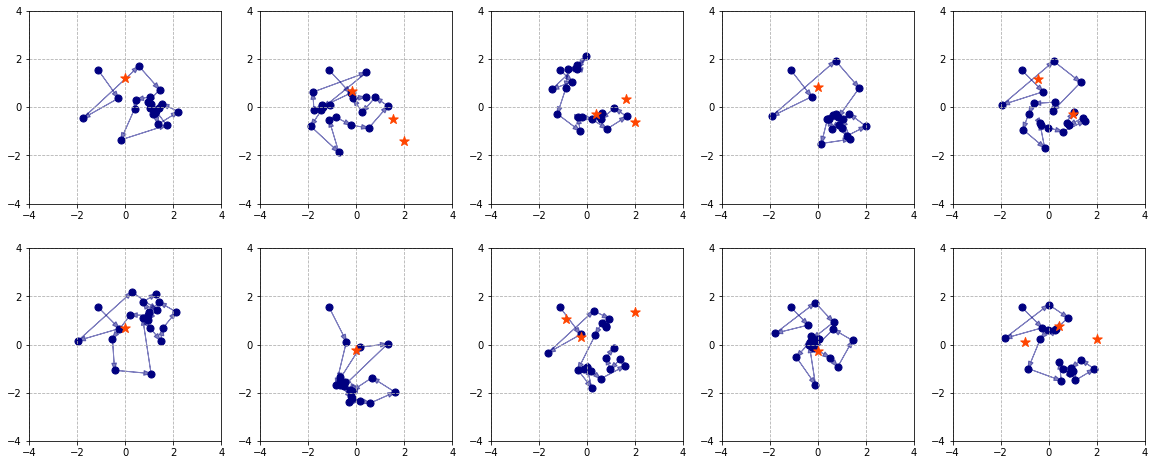

In [35]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(int(param[0])+1):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.grid(ls='--')

# Only interested in goal-oriented kld (goal)

In [55]:
data_folder = parent_dir + './results/source/multimodel/goal/'
subfolders = {'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [58]:
# read in gmm results
hs = [1, 5, 10, 15, 20, 30]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 6), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation_with_post_approx.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

/tmp/ipykernel_2214630/196506147.py:4: RuntimeWarning: Mean of empty slice
  rwds = np.nanmean(gmm_rwds[mode], axis=0)


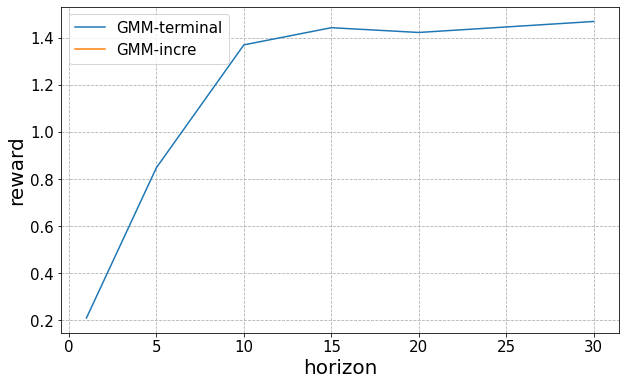

In [59]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
for mode in ['terminal', 'incre']:
    rwds = np.nanmean(gmm_rwds[mode], axis=0)
    plt.plot(hs, rwds, label=f'GMM-{mode}')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

In [60]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 1
h = 10
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

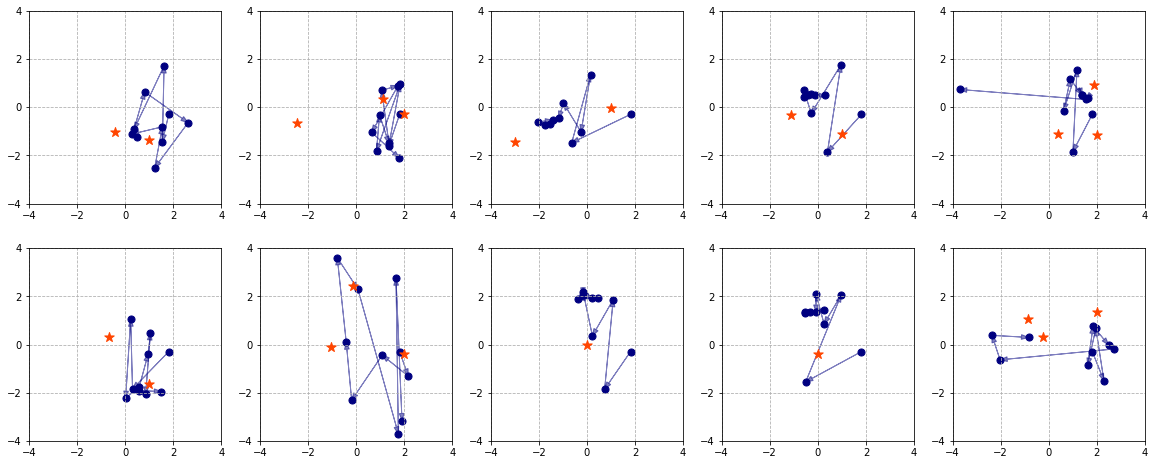

In [61]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(int(param[0])+1):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.grid(ls='--')

# model kld + parameter of interest kld (poi)

In [62]:
data_folder = parent_dir + './results/source/multimodel/model_poi/'
subfolders = {'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [63]:
# read in gmm results
hs = [1, 5, 10, 15, 20, 30]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 6), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

/tmp/ipykernel_2214630/196506147.py:4: RuntimeWarning: Mean of empty slice
  rwds = np.nanmean(gmm_rwds[mode], axis=0)


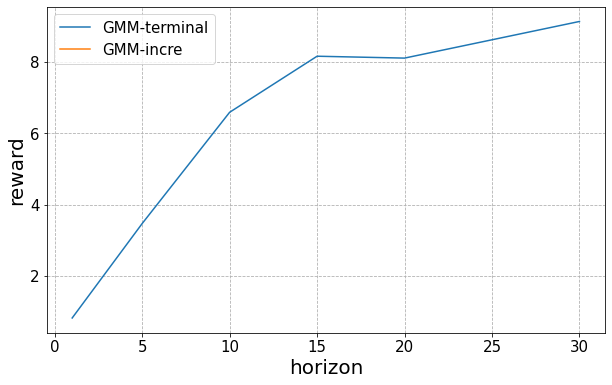

In [64]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
for mode in ['terminal', 'incre']:
    rwds = np.nanmean(gmm_rwds[mode], axis=0)
    plt.plot(hs, rwds, label=f'GMM-{mode}')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

In [65]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 1
h = 20
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

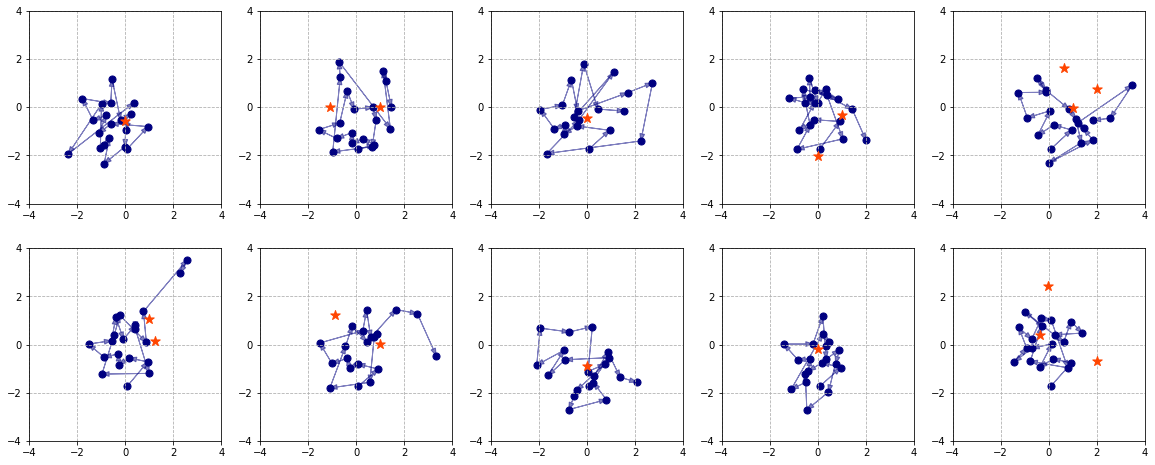

In [66]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(int(param[0])+1):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.grid(ls='--')

# model kld + goal-oriented kld (model_goal)

In [67]:
data_folder = parent_dir + './results/source/multimodel/model_goal/'
subfolders = {'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [68]:
# read in gmm results
hs = [1, 5, 10, 15, 20, 30]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 6), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation_with_post_approx.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

/tmp/ipykernel_2214630/196506147.py:4: RuntimeWarning: Mean of empty slice
  rwds = np.nanmean(gmm_rwds[mode], axis=0)


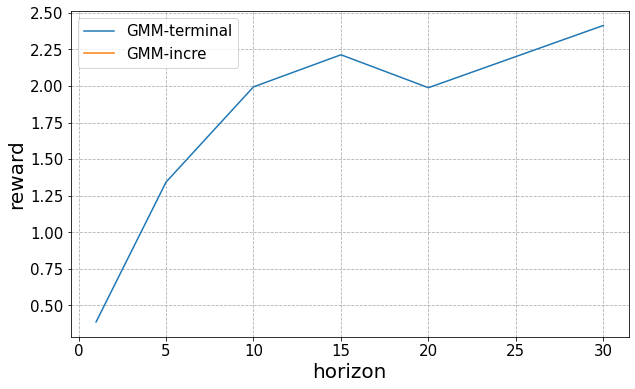

In [69]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
for mode in ['terminal', 'incre']:
    rwds = np.nanmean(gmm_rwds[mode], axis=0)
    plt.plot(hs, rwds, label=f'GMM-{mode}')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

In [70]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 1
h = 10
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

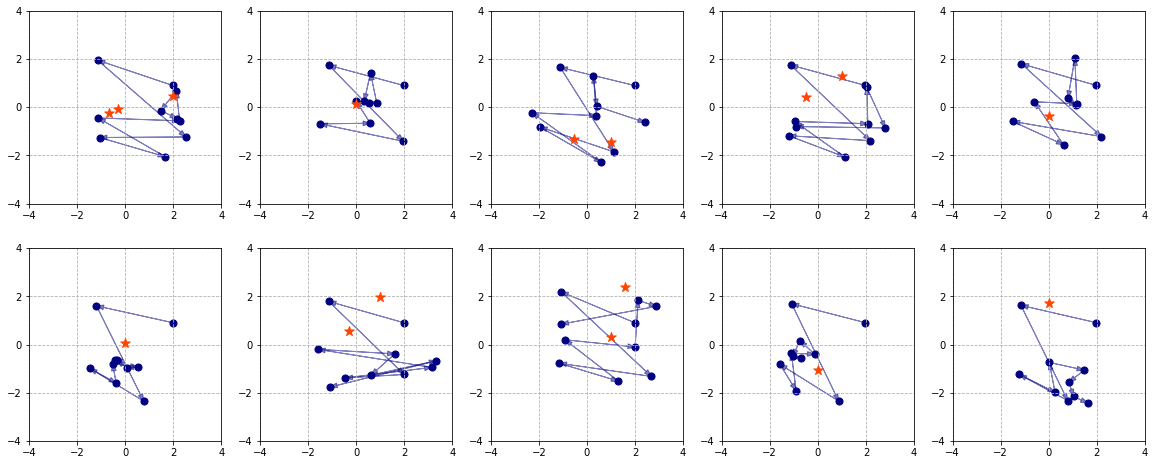

In [71]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(int(param[0])+1):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.grid(ls='--')

In [77]:
idx

array([927])

In [69]:
logpost_true = vsoed.prior.log_poi_prior(PARAM_tensor)

In [73]:
loglikeli_true = vsoed.loglikeli(h, ys_hist[0][0:1], PARAM_tensor, ds_hist[0][0:1])

In [74]:
loglikeli_true

tensor([-0.5202, -0.4946, -0.4701,  ..., -0.7691, -0.7965, -0.8219],
       dtype=torch.float64)

In [55]:
idx = 0
X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
X = X.expand(len(PARAM_tensor), -1)

In [59]:
net(X, PARAM_tensor)

tensor([-62.1698, -62.1698, -62.1698,  ..., -62.1698, -62.1698, -62.1698],
       dtype=torch.float64, grad_fn=<LogsumexpBackward0>)

In [41]:
vsoed.post_approx.form_input(h, ds_hist[0:1], ys_hist[0:1]).shape

torch.Size([1, 27])

In [38]:
logpost_pred = net(ds_hist[0:1], X_tensor)

{8: [GMM_NET(
    (feature_net): Sequential(
      (0): Linear(in_features=27, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (weight_net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=8, bias=True)
      (5): LogSoftmax(dim=1)
    )
    (mu_net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=32, bias=True)
    )
    (sigma_net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_feat

In [33]:
h

30

In [130]:
d_hist

tensor([[ 0.8792,  1.0005],
        [ 0.9809, -0.7005],
        [-0.3546,  0.4522],
        [-0.3175,  0.0342],
        [-0.9312,  0.4876],
        [-0.3273, -1.2352],
        [-1.1399,  0.1684],
        [-2.0786, -1.1481],
        [-1.9572,  0.4699],
        [-1.5191,  1.2970],
        [-0.9383,  1.3734],
        [-1.5585,  0.8526],
        [-1.0106,  0.9685],
        [-1.3715,  1.3966],
        [-1.0767,  1.9643],
        [-0.6572,  1.6295],
        [-1.0547,  1.4184],
        [-1.8630,  1.2224],
        [-1.6411,  1.2431],
        [-2.0712,  1.5780],
        [-2.1761,  1.2722],
        [-0.5260,  1.1063],
        [-0.1653,  1.0339],
        [-0.3141,  1.5050],
        [-0.0812,  0.6987],
        [ 0.0311,  0.9550],
        [ 0.0826,  0.5661],
        [-0.0612,  0.4859],
        [-0.2353,  0.2523],
        [ 0.1084,  0.3382]])

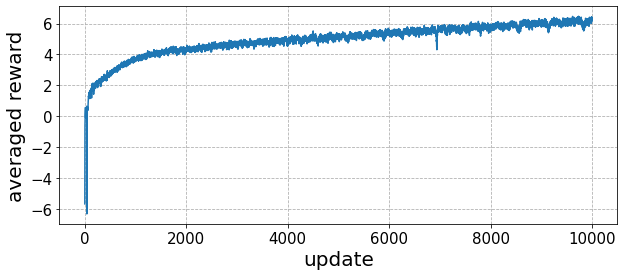

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(vsoed.update_hist[:])
plt.xlabel('update', fontsize=20)
plt.ylabel('averaged reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(linestyle='--')

In [15]:
set_random_seed(EVAL_SEEDS[0])
ret = vsoed.asses(2000, n_contrastive_sample=int(1e6), return_all=True)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

100%|██████████| 2000/2000 [00:26<00:00, 76.52it/s]


6.285343170166016

In [18]:
set_random_seed(EVAL_SEEDS[0])
ret = vsoed.asses(int(1e6), use_PCE=False, use_PCE_incre=False, return_all=True)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

6.718046188354492

In [9]:
m_true = params[:, 0].to(int)
logevid = post_approx.log_model_post(None, ds_hist, ys_hist)
evid_pred = torch.exp(logevid).cpu().detach().numpy()

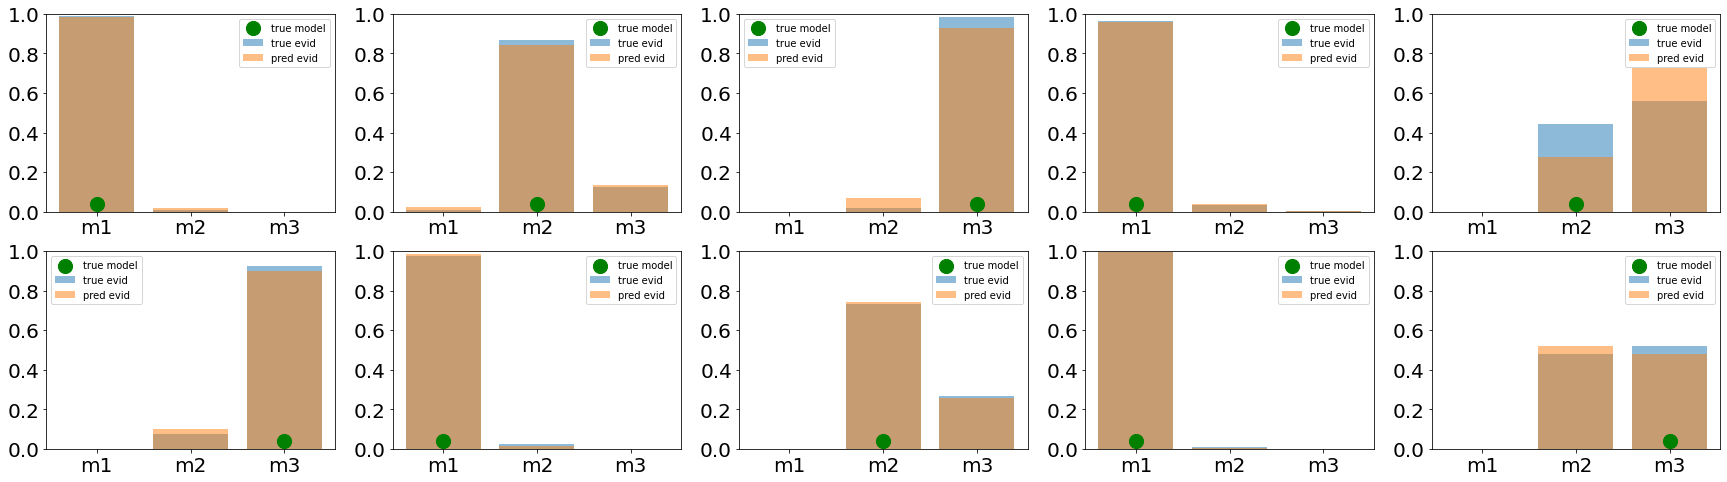

In [12]:
np.random.seed(548)
idxs = np.random.choice(len(ds_hist), 10, replace=False)
plt.figure(figsize=(30, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    loglikelis = 0
    for stage in range(n_stage):
        loglikelis += model.loglikeli(stage, ys_hist[idx:idx+1, stage, :], params, ds_hist[idx:idx+1, stage, :])
    likelis = torch.exp(loglikelis)
    evids_true = []
    for m_idx in range(len(n_pois)):
        evids_true.append(likelis[m_idx == m_true].mean().item())
    evids_true = np.array(evids_true)
    evids_true /= evids_true.sum()
    # print('evids_true: ', evids_true)
    # print('evids_pred: ', evid_pred[idx])
    plt.bar(['m1', 'm2', 'm3'], evids_true, alpha=0.5, label='true evid')
    plt.bar(['m1', 'm2', 'm3'], evid_pred[idx], alpha=0.5, label='pred evid')
    plt.scatter(m_true[idx].cpu().numpy(), 0.04, s=200, zorder=10, c='green', label='true model')
    # plt.yscale('log')
    plt.ylim(0, 1)
    plt.legend(fontsize=10)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
plt.show()

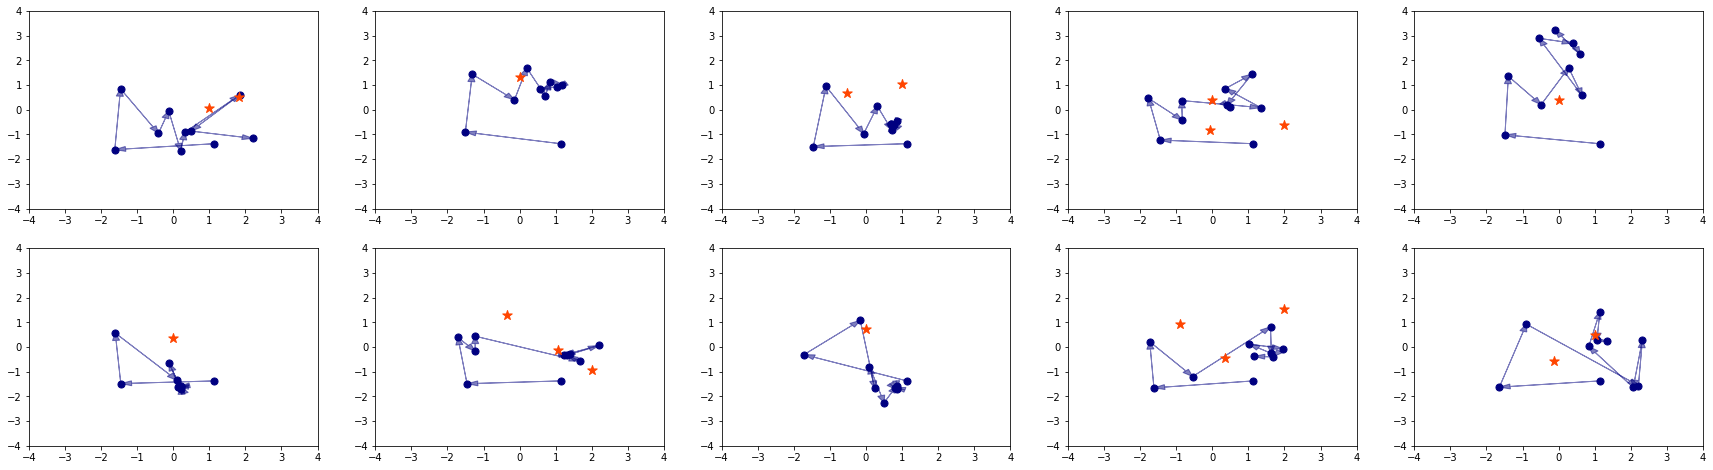

In [11]:
idxs = np.random.choice(len(ds_hist), 10, replace=False)
plt.figure(figsize=(30, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    theta = params[idx].cpu().numpy()
    d_hist = ds_hist[idx].cpu().numpy()
    y_hist = ys_hist[idx].cpu().numpy()
    for i in range(int(theta[0]) + 1):
        plt.scatter(theta[i*2], theta[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

In [20]:
from tqdm import tqdm
np.random.seed(548)
idxs = torch.from_numpy(np.random.choice(len(params), 100, replace=False)).to(device)
evid_klds = []
for idx in tqdm(idxs):
    loglikelis = 0
    for stage in range(n_stage):
        loglikelis += model.loglikeli(stage, ys_hist[idx:idx+1, stage, :], params, ds_hist[idx:idx+1, stage, :])
    likelis = torch.exp(loglikelis)
    evids_true = []
    for m_idx in range(len(n_pois)):
        evids_true.append(likelis[m_idx == m_true].mean().item())
    evids_true = np.array(evids_true)
    evids_true /= evids_true.sum()
    evid_klds.append((evids_true * np.log(evids_true * 3)).sum())
evid_klds = np.array(evid_klds)
print('evid kld: ', evid_klds.mean())

100%|██████████| 100/100 [00:01<00:00, 81.15it/s]

evid kld:  0.6345600564901903


In [23]:
ds_hist[30]

tensor([[-0.7289,  0.6698],
        [ 0.8817,  1.2228],
        [ 1.4341,  0.6463],
        [ 1.0733, -1.2968],
        [-0.8485, -0.9864],
        [ 0.3985,  0.4226],
        [ 0.2888, -0.5700],
        [ 0.0655, -0.3715],
        [-0.0392, -0.7437],
        [ 0.2918, -0.7857]], device='cuda:0')

In [25]:
rewards_hist[:, :5].sum(-1).mean()

tensor(3.6108, device='cuda:0')

In [35]:
p_max = torch.arange(1, vsoed.n_buffer_max + 1).to(torch.float32)
l_buffer = 1000000
p = p_max[:l_buffer]
p /= p.sum()
idxs_pick = torch.multinomial(p, vsoed.n_batch, replacement=False)

(array([ 112.,  307.,  480.,  745.,  934., 1096., 1278., 1487., 1672.,
        1889.]),
 array([ 10025. , 109021.9, 208018.8, 307015.7, 406012.6, 505009.5,
        604006.4, 703003.3, 802000.2, 900997.1, 999994. ]),
 <BarContainer object of 10 artists>)

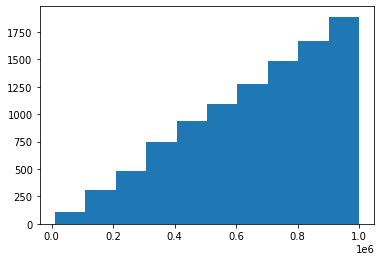

In [36]:
plt.hist(idxs_pick.cpu().numpy())

In [6]:
import joblib

In [7]:
joblib.dump(vsoed, folder + 'itr_0.pkl')

TypeError: cannot pickle 'module' object

In [9]:
vsoed.nkld_rw_f

<function vsOED.vsoed.VSOED.__init__.<locals>.nkld_rw_f(*args, **kws)>

In [51]:
torch.tensor(())

tensor([])

In [36]:
{'a': 1}.update({'b': 5})

In [10]:
np.random.choice(int(1e10), 10)

array([6377791278, 7037998855, 7556092991, 8217385358, 8695645867,
       1645853955, 1283211782, 8616980401, 3169416485, 1613878827])

In [ ]:
dict().update